In [1]:
!nvidia-smi

Sun Jul 28 02:07:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!ls drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'Colab Notebooks'   data   web


# Change Directory

In [3]:
import os
!ls drive
print(os.getcwd())
os.chdir("drive/My Drive/data/fcn_pytorch") # to project dir
print(os.getcwd())
!ls

'My Drive'
/content
/content/drive/My Drive/data/fcn_pytorch
checkpoint_fcn8s.tar  fcn8s.onnx  fcn8s.pt  log


# Import

In [0]:
import os
import re
import random
import time
import copy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import torch.optim as optim

# Setting Directory

In [0]:
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

train_data_dir = "../datasets/voc_semseg/train"
val_data_dir = "../datasets/voc_semseg/val"

train_img_dir = os.path.join(train_data_dir, 'img')
train_gt_dir = os.path.join(train_data_dir, 'gt')
val_img_dir = os.path.join(val_data_dir, 'img')
val_gt_dir = os.path.join(val_data_dir, 'gt')

# Utility Functions

In [0]:
def key_sort_by_num(x):
    re_list = re.findall(r"[0-9]+", x)
    re_list = list(map(int, re_list))
    return re_list


def list_from_dir(dir, target_ext=None):
    img_list = []
    fnames = os.listdir(dir)
    fnames = sorted(fnames, key=key_sort_by_num)
    for fname in fnames:
        if target_ext is None:
            path = os.path.join(dir, fname)
            img_list.append(path)
        else:
            _, ext = os.path.splitext(fname)
            if ext.lower() in target_ext:
                path = os.path.join(dir, fname)
                img_list.append(path)
    return img_list

In [0]:
#train_data_paths = list_from_dir(train_img_dir, ('.jpg', '.png'))
#train_gt_paths = list_from_dir(train_gt_dir, ('.jpg', '.png'))
#val_data_paths = list_from_dir(val_img_dir, ('.jpg', '.png'))
#val_gt_paths = list_from_dir(val_gt_dir, ('.jpg', '.png'))

#print(len(train_data_paths))
#print(len(train_gt_paths))
#print(len(val_data_paths))
#print(len(val_gt_paths))

In [0]:
def make_cmap():
    """ Make PASCAL VOC color map
    """
    ctbl = ((0x80, 0, 0), (0, 0x80, 0), (0, 0, 0x80),
            (0x40, 0, 0), (0, 0x40, 0), (0, 0, 0x40),
            (0x20, 0, 0), (0, 0x20, 0))

    n = 256
    lookup = np.zeros((n, 3)).astype(np.int32)
    for i in range(0, n):
        r, g, b = 0, 0, 0
        for j in range(0, 7):
            bit = (i >> j) & 1
            if bit:
                r |= ctbl[j][0]
                g |= ctbl[j][1]
                b |= ctbl[j][2]

        lookup[i, 0], lookup[i, 1], lookup[i, 2] = r, g, b
    return lookup[0:21]

In [0]:
def pil_to_tensor(pil_img):
    """ Convert from PIL to tensor
     # Arguments
            pil_img: pil img, 3 dimention(H x W x C)
    """
    img = np.array(pil_img, copy=False)
    img = img.transpose((2, 0, 1)) # H x W x C -> C x H x W
    img = img.astype(np.float32) # uint8 -> float32
    img = torch.from_numpy(img) # ndarray -> tensor
    img.div_(255)
    return img


def tensor_to_pil(tesnor_img):
    """ Convert from Tensor to PIL
     # Arguments
            tesnor_img: tensor, 3 dimention(C x H x W )
    """
    img = tesnor_img.mul(255).numpy() # tensor -> ndarray
    img = np.array(img, dtype=np.uint8) # float32 -> uint8
    img = img.transpose(1,2,0) # C x H x W -> H x W x C
    return Image.fromarray(img)


def tensor_to_ndarray(tesnor_img):
    """ Convert from Tensor to ndarray
     # Arguments
            tesnor_img: tensor, 3 dimention(C x H x W )
    """
    img = tesnor_img.mul(255).numpy() # tensor -> ndarray
    img = np.array(img, dtype=np.uint8) # float32 -> uint8
    img = img.transpose(1,2,0) # C x H x W -> H x W x C
    return img


def pil_to_one_hot_array(label_array, classes, size):
    """ Convert from PIL to one-hot-array
     # Arguments
            label_array: ndarray, 3 dimention(H x W x C)
            classes: int, num of class
            size: int, image size
    """
    x = np.zeros((classes, size, size)) # C x H x W
    
    for i in range(size):
        for j in range(size):
            x[label_array[i][j], i, j] = 1

    return x


def pred_to_pil(pred):
    """ Convert from one-hot-array to PIL
     # Arguments
            pred: tensor, 3 dimention(C x H x W)
    """
    cmap = make_cmap()
    
    pred_ = pred.numpy() # tensor -> ndarray
    channel, _, _ = pred_.shape
    pred_ = pred_.transpose(1, 2, 0) # C x H x W -> H x W x C
    pred_ = np.argmax(pred_, axis=2) #  H x W x C -> H x W
    
    row, col = pred_.shape
    dst = np.ones((row, col, 3))
    
    for i in range(channel):
        dst[pred_ == i] = cmap[i]

    dst = dst.astype(np.uint8)
    return  Image.fromarray(dst) # ndarray -> PIL

In [0]:
class ResizeAndPadding:
    def __init__(self, size, interpolation=Image.BILINEAR, pad=True):
        self.size = size
        self.interpolation = interpolation
        self.pad = pad

    def __call__(self, img):
        """Resize and Padding
         # Arguments
                img: pil img, 3 dimention(H x W x C)
        """
        size_wh = img.size

        ratio = float(self.size)/max(size_wh)
        new_size_wh = tuple([int(x * ratio) for x in size_wh])

        img = img.resize(new_size_wh, resample=self.interpolation)

        if self.pad:
            mode = img.mode
            new_img = Image.new(mode, (self.size, self.size))
            new_img.paste(img,
                                       ((self.size-new_size_wh[0])//2,
                                         (self.size-new_size_wh[1])//2))
        else:
            new_img = img

        return new_img

    
class RandomCropForSemseg:
    def __init__(self, size):
        self.target_size = size
        
    def __call__(self, img, target=None):
        """Random crop img and label
         # Arguments
                img: pil img, 3 dimention(H x W x C)
                target: label img, 3 dimention(H x W x C)
        """
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(self.target_size,self.target_size))
        img = TF.crop(img, i, j, h, w)
        if target is not None:
            target = TF.crop(target, i, j, h, w)
            
        return img, target
    
    
class RandomFlipForSemseg:
    def __init__(self):
            pass

    def __call__(self, img, target=None):
        """Random flip img and label
         # Arguments
                img: pil img, 3 dimention(H x W x C)
                target: label img, 3 dimention(H x W x C)
        """
        if random.random() < 0.5:
            img = TF.hflip(img)
            if target is not None:
                target = TF.hflip(target)

        return img, target

In [0]:
def show_imgs(imgs, size,  figsize=[6.4, 4.8], converter=False):
    """Show images
     # Arguments
            imgs: 1-D array, 4 dimention(batch x H x W x C)
            row: Int, row for plt.subplot
            col: Int, column for plt.subplot
    """
    row, col = size
    if len(imgs) != (row * col):
        raise ValueError("Invalid imgs len:{} col:{} row:{}".format(len(imgs), row, col))

  
    plt.figure(figsize=figsize)
    plt.tight_layout()

    for i, img in enumerate(imgs):
        if converter:
            img = converter(img)
        plot_num = i+1
        plt.subplot(row, col, plot_num)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Create Dataset and DataLoader

In [0]:
class SemSegDataset(Dataset):
    
    def __init__(self, classes, input_size, img_dir, target_dir=None, train=False):
        self.classes = classes
        self.input_size = input_size
        self.img_paths, self.target_paths = self._get_paths(img_dir, target_dir)
        self.train = train
     
        #-------------------------------------------
        # transforms
        #-------------------------------------------
        self.trans_resize_and_pad = ResizeAndPadding(self.input_size)
        self.train_trans_crop = RandomCropForSemseg(self.input_size)
        self.train_trans_flip = RandomFlipForSemseg()
        self.eval_trns = transforms.Compose([
            transforms.CenterCrop(self.input_size)
        ])

        #-------------------------------------------
        # check data num
        #-------------------------------------------
        img_num = len(self.img_paths)
        if target_dir:
            target_num = len(self.target_paths)
            assert img_num == target_num, "img/gt not equal, img:{} gt:{}".format(img_num, target_num)
        
        self.data_num = img_num

        
    def __len__(self):
        return self.data_num
    
    
    def _get_paths(self, img_dir, target_dir):
        img_paths = list_from_dir(img_dir, ('.jpg', '.png'))
        if target_dir:
            target_paths = list_from_dir(target_dir, ('.jpg', '.png'))
        else:
            target_paths = None
            
        return img_paths, target_paths
    
    
    def _transform(self, img, target, train):
        
        #-------------------------------------------
        # Padding and Resize if needed
        #-------------------------------------------
        if min(img.size) < self.input_size:            
            img = self.trans_resize_and_pad(img)
            if target:
                target = self.trans_resize_and_pad(target)

        
        if train:
            #-------------------------------------------
            # Random Crop
            #-------------------------------------------
            img, target = self.train_trans_crop(img, target)
      
            #-------------------------------------------
            # Random Flip
            #-------------------------------------------
            img, target = self.train_trans_flip(img, target)
    
        else:
            #-------------------------------------------
            # Evaluation
            #-------------------------------------------
            img = self.eval_trns(img)
            if target:
                target = self.eval_trns(target)
     
        img = pil_to_tensor(img) # 0-255 -> 0-1
        
        if target:
            target = np.asarray(target, dtype=np.int32)
            target[target == 255] = 0  # 境界部分をbackgroundクラスにする

            target = pil_to_one_hot_array(target, self.classes, self.input_size)
            target = torch.from_numpy(target).long() # ラベルをtensor型に変換
        
        return img, target

    def __getitem__(self, idx):
        assert idx < self.data_num,"invalid idx {}, max idx is {}".format(idx, self.data_num-1)
        
        img = Image.open(self.img_paths[idx])
        if self.target_paths:
            target = Image.open(self.target_paths[idx])
        else:
            target = None
        
        x, y = self._transform(img, target, self.train)

        return x, y

In [0]:
train_dataset = SemSegDataset(21, 224, train_img_dir, train_gt_dir, train=True)
val_dataset    = SemSegDataset(21, 224, val_img_dir, val_gt_dir, train=False)

In [0]:
x,y = train_dataset[0]

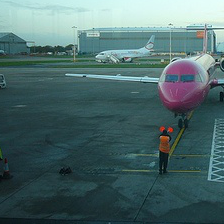

In [16]:
tensor_to_pil(x)

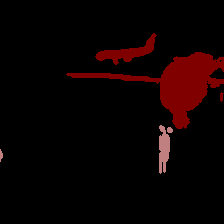

In [17]:
pred_to_pil(y)

In [0]:
train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=4)
val_dataloader    = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=4)

torch.Size([24, 3, 224, 224])
torch.Size([24, 21, 224, 224])


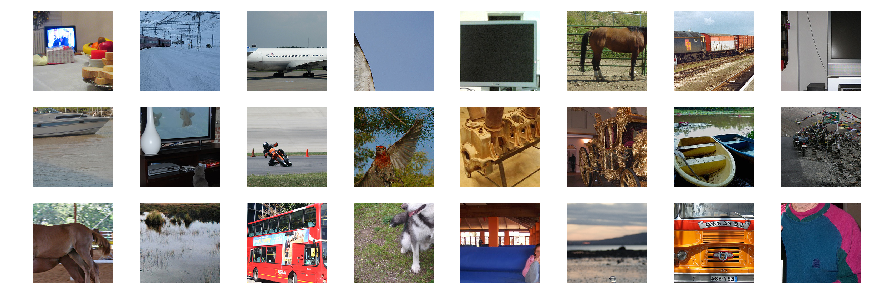

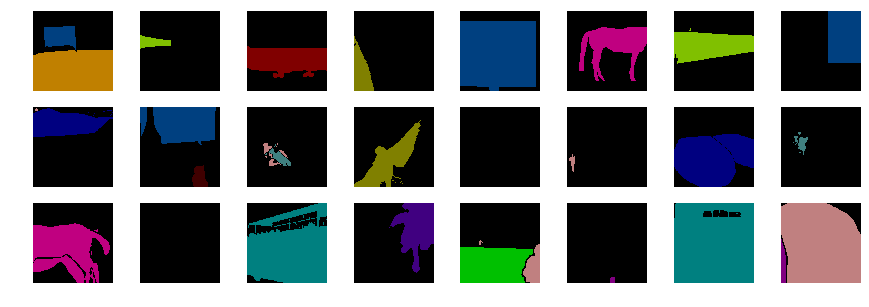

In [19]:
for d in train_dataloader:
    print(d[0].shape)
    print(d[1].shape)
    break
    
            
show_imgs(d[0], [3, 8], figsize=(15,5), converter=tensor_to_ndarray)
show_imgs(d[1], [3, 8], figsize=(15,5), converter=pred_to_pil)

# Define Model

In [0]:
# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/models/fcn32s.py
def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """
    Make a 2D bilinear kernel suitable for upsampling
    """
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
             (1 - abs(og[1] - center) / factor)
    
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt

    return torch.from_numpy(weight).float()

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock

class EncorderResNet(ResNet):
    
    def __init__(self, layers=[2, 2, 2, 2]):
        super().__init__(BasicBlock, layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x3 = x
        x = self.layer3(x)
        x4 = x
        x = self.layer4(x)
        x5 = x
        
        return x3, x4, x5

In [0]:
class FCN32s(nn.Module):
    
    def __init__(self, num_classes, encorder):
        super().__init__()
        
        self.encorder = encorder
        
        self.relu = nn.ReLU(inplace=True)
        
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=64, stride=32, padding=16,
                                                                       bias=False)
        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
                
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
               
        x = self.score5(x5)
        
        x = self.upscore(x)
        
        return x

In [0]:
class FCN16s(nn.Module):
    
    def __init__(self, num_classes, encorder):
        super().__init__()
        
        self.encorder = encorder
           
        self.score4 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        self.upscore4 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=4, stride=2, padding=1,
                                                                       bias=False)
        self.upscore5 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=8, stride=4, padding=2,
                                                                       bias=False)
 
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=16, stride=8, padding=4,
                                                                       bias=False)

        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
    
    
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
                
        x4 = self.score4(x4)
        x5 = self.score5(x5)
        
        x4 = self.upscore4(x4)
        x5 = self.upscore5(x5)
        
        x = x4 + x5
        
        x = self.upscore(x)
        
        return x

In [0]:
class FCN8s(nn.Module):
    
    def __init__(self, num_classes, encorder, bilinear=False):
        super().__init__()
        
        self.bilinear = bilinear
        
        self.encorder = encorder
           
        self.score3 = nn.Conv2d(128, num_classes, kernel_size=1)
        self.score4 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score5 = nn.Conv2d(512, num_classes, kernel_size=1)

        self.upscore4 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=4, stride=2, padding=1,
                                                                       bias=False)
        self.upscore5 = nn.ConvTranspose2d(num_classes, num_classes,
                                                                       kernel_size=8, stride=4, padding=2,
                                                                       bias=False)

        if not self.bilinear:
            self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                                                           kernel_size=16, stride=8, padding=4,
                                                                           bias=False)

        self._init_weight()
        
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                init_w = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(init_w)
        
    def forward(self, x):
        
        x3, x4, x5 = self.encorder(x)
                
        x3 = self.score3(x3)
        x4 = self.score4(x4)
        x5 = self.score5(x5)     

        x4 = self.upscore4(x4) # x2
        x5 = self.upscore5(x5) # x4
        
        x = x3 + x4 + x5
        
        if self.bilinear:
            x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)
        else:
            x = self.upscore(x) # x8
        
        return x

In [0]:
from torchvision.models import resnet18
def build_encorder():
    encorder = EncorderResNet(layers=[2, 2, 2, 2])
    encorder.load_state_dict(resnet18(pretrained=True).state_dict())
    return encorder

# Create Model

In [26]:
encorder = build_encorder()
model = FCN8s(num_classes=21, encorder=encorder)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:10<00:00, 4429232.11it/s]


In [27]:
from torchsummary import summary
summary(model,  input_size=(3, 224, 224),   device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Define Trainer

In [28]:
# pip install tqdm
pip install fastprogress

In [0]:
# from tqdm import tqdm_notebook as tqdm
from fastprogress import master_bar, progress_bar
import copy
import time


def calc_acc(preds, labels):
    correct = (preds == labels).sum()
    total     = (labels == labels).sum()
    correct = correct.to(torch.float32)
    total     = total.to(torch.float32)
    return (correct / total)


class Trainer:
    
    def __init__(self, model, device, optimizer, criterion, train_loader, val_loader=None,
                          scheduler=None, history=None, prev_epochs=0):

        self.print_state = True
        
        self.done_epochs = prev_epochs # 0-
        
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        
        self.scheduler = scheduler
        
        self.best_val_acc = 0.0
        self.best_model_wts = copy.deepcopy(model.state_dict())
        
        if history:
            self.history = history
        else:
            self.history = {'epoch':[], 'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}
        
        self.train_loader = train_loader
        self.train_data_num = len(self.train_loader.dataset)
        self.train_sptes_per_epoch = len(self.train_loader)
        
        self.val_loader = val_loader
        if self.val_loader:
            self.val_data_num = len(self.val_loader.dataset)
            self.val_sptes_per_epoch = len(self.val_loader)
        else:
            self.val_data_num = 0
            self.val_sptes_per_epoch = 0

        self.model.to(self.device)
        
        
    def set_print_state(self, state=True):
        self.print_state = state
        
        
    def train_loop(self, epochs):
        total_epochs = self.done_epochs + epochs

        #------------------------------------------------------------------------
        # pre print
        #------------------------------------------------------------------------        
        if self.print_state:
            print("Device :  ", self.device)
            print("Train on {} samples, validate on {} samples".format(self.train_data_num,
                                                                                                                 self.val_data_num))
            for i in range(self.done_epochs):
                done_history_idx = i
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f}".format(
                        i+1, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx]))

        #------------------------------------------------------------------------
        # training loop
        #------------------------------------------------------------------------
        for _ in range(epochs):
            self.history['epoch'].append(self.done_epochs+1) # 1-
            
            start_time = time.time()            
            train_score = self._train_one_epoch()
            end_time = time.time()
            
            self.history['train_acc'].append(train_score['acc'])
            self.history['train_loss'].append(train_score['loss'])
            
            if self.val_loader:
                val_score = self._val_one_epoch()
                self.history['val_acc'].append(val_score['acc'])
                self.history['val_loss'].append(val_score['loss'])
                
                if self.best_val_acc < val_score['acc']:
                    self.best_val_acc = val_score['acc']
                    self.best_model_wts = copy.deepcopy(self.model.state_dict())
                
                if self.scheduler:
                    self.scheduler.step(val_score['loss'])
                    
            else:
                if self.scheduler:
                    self.scheduler.step(train_score['loss'])
                

            self.done_epochs += 1

            #------------------------------------------------------------------------
            # post print
            #------------------------------------------------------------------------
            if self.print_state:
                elapsed_time = end_time-start_time
                done_history_idx = self.done_epochs-1
                if self.val_loader:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['train_acc'][done_history_idx],
                        self.history['train_loss'][done_history_idx],
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))
                else:
                    print("Epoch:{}/{} train_acc:{:.4f}% train_loss:{:.4f} time:{:.3f}".format(
                        self.done_epochs, total_epochs,
                        self.history['val_acc'][done_history_idx],
                        self.history['val_loss'][done_history_idx],
                        elapsed_time))

                    
    def _one_step(self, data, labels, train=True):
            if train:
                self.optimizer.zero_grad()
            
            outputs = self.model(data)
            
            # (batchsize x C x H x W) -> (bachsize x H x W)
            labels = torch.argmax(labels, dim=1, keepdim=False)
            preds = torch.argmax(outputs, dim=1, keepdim=False)
            
            loss = self.criterion(outputs, labels)
            
            if train:
                loss.backward()
                self.optimizer.step()
            
            correct = calc_acc(preds, labels)

            return loss.item(), correct.item()

        
    def _train_one_epoch(self):
        self.model.train()
        
        running_loss = 0
        running_correct = 0

        #for batch_idx, (data, labels) in enumerate(self.train_loader):
        #for batch_idx, (data, labels) in tqdm(enumerate(self.train_loader)):
        for batch_idx, (data, labels) in enumerate(progress_bar(self.train_loader)): # naka
            data, labels = data.to(self.device), labels.to(self.device)
            
            loss, correct = self._one_step(data, labels, train=True)
    
            running_loss       += loss
            running_correct += correct

        train_loss = running_loss      / self.train_sptes_per_epoch
        train_acc = running_correct / self.train_sptes_per_epoch
        
        return {'loss':train_loss, 'acc':train_acc}

    
    def _val_one_epoch(self):
        self.model.eval()
        
        running_loss = 0
        running_correct = 0

        with torch.no_grad():
            for data, labels in self.val_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                
                loss, correct = self._one_step(data, labels, train=False)

                running_loss       += loss
                running_correct += correct
                
        val_loss = running_loss      / self.val_sptes_per_epoch
        val_acc = running_correct / self.val_sptes_per_epoch

        return {'loss':val_loss, 'acc':val_acc}

    
    def save_best_model(self, path):
        torch.save(self.best_model_wts, path)
    

    def save_checkpoint(self, path):
        ckpt = {
            'model_satate_dict':self.model.state_dict(),
            'optimizer_state_dict':self.optimizer.state_dict(),
            'history':self.history
        }
        torch.save(ckpt, path)

# Start Training

In [30]:
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss() # nn.LogSoftmax() + nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1,
                                                                                            patience=6,  verbose=True) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
trainer = Trainer(model, device, optimizer, criterion, train_dataloader, val_dataloader,scheduler=exp_lr_scheduler)

cuda:0


In [31]:
trainer.train_loop(60)

Device :   cuda:0
Train on 1464 samples, validate on 1449 samples


Epoch:1/60 train_acc:0.7112% train_loss:1.1533 val_acc:0.7337% val_loss:0.8495 time:204.823


Epoch:2/60 train_acc:0.7843% train_loss:0.6934 val_acc:0.7657% val_loss:0.7409 time:53.333


Epoch:3/60 train_acc:0.8139% train_loss:0.5907 val_acc:0.7702% val_loss:0.7316 time:53.068


Epoch:4/60 train_acc:0.8262% train_loss:0.5400 val_acc:0.7766% val_loss:0.7252 time:52.529


Epoch:5/60 train_acc:0.8393% train_loss:0.4891 val_acc:0.7835% val_loss:0.6994 time:53.010


Epoch:6/60 train_acc:0.8488% train_loss:0.4643 val_acc:0.7818% val_loss:0.7152 time:53.013


Epoch:7/60 train_acc:0.8536% train_loss:0.4403 val_acc:0.7801% val_loss:0.7466 time:52.438


Epoch:8/60 train_acc:0.8636% train_loss:0.4125 val_acc:0.7884% val_loss:0.6942 time:52.413


Epoch:9/60 train_acc:0.8698% train_loss:0.3842 val_acc:0.7909% val_loss:0.6979 time:52.363


Epoch:10/60 train_acc:0.8777% train_loss:0.3599 val_acc:0.7962% val_loss:0.6732 time:52.244


Epoch:11/60 train_acc:0.8852% train_loss:0.3392 val_acc:0.8011% val_loss:0.6763 time:52.400


Epoch:12/60 train_acc:0.8841% train_loss:0.3438 val_acc:0.7966% val_loss:0.6855 time:52.515


Epoch:13/60 train_acc:0.8917% train_loss:0.3152 val_acc:0.8045% val_loss:0.6667 time:52.947


Epoch:14/60 train_acc:0.8929% train_loss:0.3144 val_acc:0.8014% val_loss:0.6706 time:52.447


Epoch:15/60 train_acc:0.8979% train_loss:0.3010 val_acc:0.8016% val_loss:0.6788 time:52.613


Epoch:16/60 train_acc:0.9025% train_loss:0.2844 val_acc:0.7993% val_loss:0.7108 time:52.482


Epoch:17/60 train_acc:0.9048% train_loss:0.2791 val_acc:0.7986% val_loss:0.6987 time:52.445


Epoch:18/60 train_acc:0.9034% train_loss:0.2838 val_acc:0.7954% val_loss:0.7281 time:52.659


Epoch:19/60 train_acc:0.9059% train_loss:0.2734 val_acc:0.8072% val_loss:0.6724 time:52.511


Epoch:20/60 train_acc:0.9100% train_loss:0.2631 val_acc:0.8137% val_loss:0.6359 time:52.524


Epoch:21/60 train_acc:0.9118% train_loss:0.2540 val_acc:0.8092% val_loss:0.6707 time:52.735


Epoch:22/60 train_acc:0.9106% train_loss:0.2575 val_acc:0.8088% val_loss:0.6609 time:52.698


Epoch:23/60 train_acc:0.9174% train_loss:0.2375 val_acc:0.8119% val_loss:0.6641 time:52.287


Epoch:24/60 train_acc:0.9179% train_loss:0.2338 val_acc:0.8043% val_loss:0.6981 time:52.393


Epoch:25/60 train_acc:0.9194% train_loss:0.2303 val_acc:0.8082% val_loss:0.6857 time:52.491


Epoch:26/60 train_acc:0.9191% train_loss:0.2329 val_acc:0.8133% val_loss:0.6643 time:52.531


Epoch    26: reducing learning rate of group 0 to 1.0000e-03.
Epoch:27/60 train_acc:0.9197% train_loss:0.2298 val_acc:0.8106% val_loss:0.6944 time:52.923


Epoch:28/60 train_acc:0.9215% train_loss:0.2233 val_acc:0.8180% val_loss:0.6608 time:52.204


Epoch:29/60 train_acc:0.9280% train_loss:0.2052 val_acc:0.8192% val_loss:0.6489 time:52.706


Epoch:30/60 train_acc:0.9277% train_loss:0.2042 val_acc:0.8200% val_loss:0.6443 time:52.900


Epoch:31/60 train_acc:0.9291% train_loss:0.2027 val_acc:0.8204% val_loss:0.6440 time:52.438


Epoch:32/60 train_acc:0.9293% train_loss:0.2004 val_acc:0.8200% val_loss:0.6526 time:52.300


Epoch:33/60 train_acc:0.9283% train_loss:0.2041 val_acc:0.8213% val_loss:0.6397 time:52.484


Epoch    33: reducing learning rate of group 0 to 1.0000e-04.
Epoch:34/60 train_acc:0.9300% train_loss:0.1994 val_acc:0.8209% val_loss:0.6398 time:52.284


Epoch:35/60 train_acc:0.9313% train_loss:0.1943 val_acc:0.8210% val_loss:0.6367 time:51.992


Epoch:36/60 train_acc:0.9299% train_loss:0.1994 val_acc:0.8202% val_loss:0.6496 time:52.208


Epoch:37/60 train_acc:0.9296% train_loss:0.1967 val_acc:0.8219% val_loss:0.6374 time:52.108


Epoch:38/60 train_acc:0.9300% train_loss:0.1993 val_acc:0.8203% val_loss:0.6447 time:51.892


Epoch:39/60 train_acc:0.9299% train_loss:0.1990 val_acc:0.8209% val_loss:0.6446 time:52.306


Epoch:40/60 train_acc:0.9299% train_loss:0.1977 val_acc:0.8213% val_loss:0.6387 time:52.005


Epoch    40: reducing learning rate of group 0 to 1.0000e-05.
Epoch:41/60 train_acc:0.9305% train_loss:0.1965 val_acc:0.8213% val_loss:0.6395 time:52.075


Epoch:42/60 train_acc:0.9312% train_loss:0.1969 val_acc:0.8211% val_loss:0.6412 time:52.274


Epoch:43/60 train_acc:0.9298% train_loss:0.2000 val_acc:0.8218% val_loss:0.6359 time:51.886


Epoch:44/60 train_acc:0.9335% train_loss:0.1898 val_acc:0.8215% val_loss:0.6384 time:51.945


Epoch:45/60 train_acc:0.9295% train_loss:0.1982 val_acc:0.8212% val_loss:0.6420 time:52.246


Epoch:46/60 train_acc:0.9289% train_loss:0.2019 val_acc:0.8225% val_loss:0.6346 time:52.222


Epoch:47/60 train_acc:0.9303% train_loss:0.1962 val_acc:0.8214% val_loss:0.6460 time:52.047


Epoch:48/60 train_acc:0.9320% train_loss:0.1942 val_acc:0.8223% val_loss:0.6354 time:52.112


Epoch:49/60 train_acc:0.9328% train_loss:0.1916 val_acc:0.8219% val_loss:0.6314 time:52.036


Epoch:50/60 train_acc:0.9308% train_loss:0.1979 val_acc:0.8212% val_loss:0.6457 time:52.053


Epoch:51/60 train_acc:0.9311% train_loss:0.1950 val_acc:0.8210% val_loss:0.6405 time:52.071


Epoch:52/60 train_acc:0.9290% train_loss:0.2013 val_acc:0.8217% val_loss:0.6379 time:52.344


Epoch:53/60 train_acc:0.9318% train_loss:0.1950 val_acc:0.8214% val_loss:0.6385 time:52.075


Epoch:54/60 train_acc:0.9311% train_loss:0.1956 val_acc:0.8221% val_loss:0.6408 time:52.186


Epoch:55/60 train_acc:0.9305% train_loss:0.1978 val_acc:0.8224% val_loss:0.6298 time:51.893


Epoch:56/60 train_acc:0.9296% train_loss:0.2012 val_acc:0.8220% val_loss:0.6359 time:51.937


Epoch:57/60 train_acc:0.9278% train_loss:0.2050 val_acc:0.8207% val_loss:0.6482 time:51.961


Epoch:58/60 train_acc:0.9306% train_loss:0.1979 val_acc:0.8218% val_loss:0.6413 time:51.969


Epoch:59/60 train_acc:0.9299% train_loss:0.1970 val_acc:0.8215% val_loss:0.6367 time:52.149


Epoch:60/60 train_acc:0.9308% train_loss:0.1949 val_acc:0.8215% val_loss:0.6376 time:52.253


In [0]:
# trainer.save_checkpoint('checkpoint_fcn8s.tar')
# trainer.save_best_model('fcn8s.pt')

# Plot acc and loss curve

In [0]:
def plot_history(history):
    
    epochs = len(history['train_acc'],)
    
    xaxis = range(epochs)
    plt.figure()
    plt.plot(xaxis, history['train_acc'], 'r-', label='train_acc')
    plt.plot(xaxis, history['val_acc'], 'b-', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')


    plt.figure()
    plt.plot(xaxis, history['train_loss'], 'r-', label='train_loss')
    plt.plot(xaxis, history['val_loss'], 'b-', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

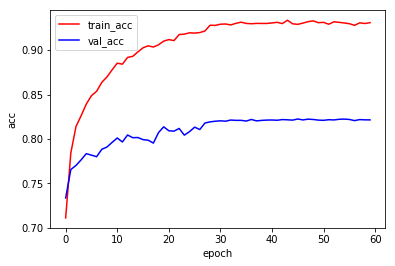

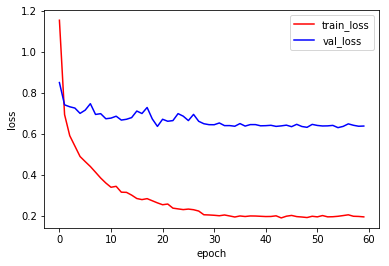

In [33]:
plot_history(trainer.history)

# Evaluate

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('fcn8s.pt', map_location=device))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
 classnames=[
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boad",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "dining table",
    "dog",
    "horse",
    "motor_bike",
    "person",
    "potted_plant",
    "sheep",
    "sofa",
    "train",
    "tv"]

In [0]:
def evaluate(model, device, criterion, test_loader):
    model.eval()
    runnning_loss = 0
    running_correct = 0
    with torch.no_grad():
        for data in progress_bar(test_loader):
            imgs, labels = data            
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            
            labels = torch.argmax(labels, dim=1, keepdim=False)
            pred = torch.argmax(outputs, dim=1, keepdim=False)
            runnning_loss += criterion(outputs, labels).item()
            running_correct += calc_acc(pred, labels)
            
    test_acc = running_correct / len(test_loader)
    test_loss = runnning_loss / len(test_loader)

    return {'loss':test_loss, 'acc':test_acc}

In [37]:
test_loader = val_dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

model = model.to(device)
test_score = evaluate(model, device, criterion, test_loader)

device: cuda


In [38]:
print('acc  : {:.4f}'.format(test_score['acc']))
print('loss : {:.4f}'.format(test_score['loss']) )

acc  : 0.8040
loss : 0.7238


# Predict

In [0]:
def predict(model, device, imgs):
    model.eval()
    
    if len(imgs.size()) != 4:
        imgs = imgs.unsqueeze(0)
    imgs = imgs.to(device)
    
    with torch.no_grad():
        output = model(imgs)
        
    return output

In [0]:
device = 'cpu'
img, label = val_dataset[11]
model.to(device)
out = predict(model, device, img)

label_pil = pred_to_pil(label)
out_pil = pred_to_pil(out[0])
input_pil = tensor_to_pil(img)

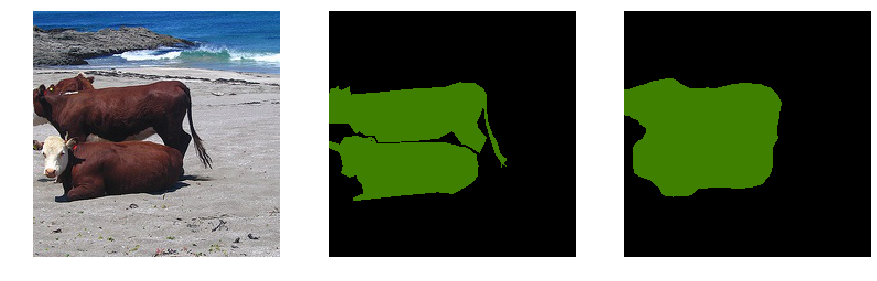

In [41]:
show_imgs([input_pil, label_pil, out_pil], [1, 3], figsize=(15,5))

# Save as ONNX

In [0]:
# pip install torchvision==0.2.1
import torch
dummy_input = torch.randn(1, 3, 224, 224,)
torch_out = torch.onnx.export(model, dummy_input, "fcn8s.onnx", verbose=True)

In [0]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

# Optuna

In [0]:
!pip install optuna

In [0]:
import optuna

In [0]:
import torch.optim as optim

def create_optimizer(trial, model):
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)

    optimizer_name = trial.suggest_categorical('optimizer', ['MomentumSGD', 'Adam', 'AdaBound', 'ASGD', 'Adamax'])
    if optimizer_name == 'MomentumSGD':
        lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == 'Adam':
        lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'AdaBound':
        lr = trial.suggest_loguniform('adabound_lr', 1e-5, 1e-1)
        optimizer = AdaBound(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'ASGD':
        lr = trial.suggest_loguniform('asgd_lr', 1e-5, 1e-1)
        optimizer = optim.ASGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'Adamax':
        lr = trial.suggest_loguniform('adamax_lr', 1e-5, 1e-1)
        optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError('invalid name:', optimizer_name)

    return optimizer


def create_activation(trial):
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'ELU'])
    
    if  activation_name == 'ReLU':
        activation = F.relu
    elif activation_name =='ELU':
        activation = F.elu
    else:
        raise ValueError('invalid name:', activation_name)
    
    return activation


def create_dropoutrate(trial):
    return trial.suggest_uniform('dropout_prob', 0, 0.8)


def is_bilinear(trial):
    upsampling = trial.suggest_categorical('upsampling', ['ConvTranspose2d', 'bilinear'])
    if upsampling == 'bilinear':
        bilinear = True
    else:
        bilinear = False
    return bilinear

In [0]:
def objective(trial):
    EPOCH = 1
    
    encorder = build_encorder()
    model = FCN8s(num_classes=21, encorder=encorder, bilinear=is_bilinear(trial))
    
    optimizer = create_optimizer(trial, model)

        
    #-----------------------------------------
    # build model
    #-----------------------------------------
    criterion = nn.CrossEntropyLoss() # nn.LogSoftmax() + nn.NLLLoss()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainer = Trainer(model, device, optimizer, criterion, train_dataloader, val_dataloader)

    #-----------------------------------------
    # start training
    #-----------------------------------------
    trainer.train_loop(EPOCH)

    #-----------------------------------------
    # get validation loss
    #-----------------------------------------
    last_val_loss = trainer.history['val_loss'][-1]

    return last_val_loss

In [0]:
study = optuna.create_study()
study.optimize(objective, n_trials=60)

Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4906% train_loss:10.1419 val_acc:0.5507% val_loss:2.0071 time:54.530


[I 2019-05-01 21:32:21,209] Finished trial#0 resulted in value: 2.007104209212006. Current best value is 2.007104209212006 with parameters: {'upsampling': 'bilinear', 'weight_decay': 0.0007367192289155129, 'optimizer': 'AdaBound', 'adabound_lr': 0.0905599407885189}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4462% train_loss:14.2479 val_acc:0.3722% val_loss:2.3499 time:53.754


[I 2019-05-01 21:34:09,847] Finished trial#1 resulted in value: 2.3498693020617374. Current best value is 2.007104209212006 with parameters: {'upsampling': 'bilinear', 'weight_decay': 0.0007367192289155129, 'optimizer': 'AdaBound', 'adabound_lr': 0.0905599407885189}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6125% train_loss:1.5667 val_acc:0.7257% val_loss:0.9498 time:54.742


[I 2019-05-01 21:35:56,239] Finished trial#2 resulted in value: 0.9497899403337573. Current best value is 0.9497899403337573 with parameters: {'upsampling': 'bilinear', 'weight_decay': 0.0005990299793681167, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.0016388467006844482}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5266% train_loss:1.9877 val_acc:0.7297% val_loss:1.1253 time:54.610


[I 2019-05-01 21:37:44,757] Finished trial#3 resulted in value: 1.125325014356707. Current best value is 0.9497899403337573 with parameters: {'upsampling': 'bilinear', 'weight_decay': 0.0005990299793681167, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.0016388467006844482}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5207% train_loss:2.0888 val_acc:0.6332% val_loss:1.4759 time:53.664


[I 2019-05-01 21:39:33,075] Finished trial#4 resulted in value: 1.4758859188830267. Current best value is 0.9497899403337573 with parameters: {'upsampling': 'bilinear', 'weight_decay': 0.0005990299793681167, 'optimizer': 'MomentumSGD', 'momentum_sgd_lr': 0.0016388467006844482}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6709% train_loss:1.2922 val_acc:0.7596% val_loss:0.8250 time:54.597


[I 2019-05-01 21:41:19,507] Finished trial#5 resulted in value: 0.8249809351123747. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4787% train_loss:12.2318 val_acc:0.5529% val_loss:2.4194 time:54.984


[I 2019-05-01 21:43:08,179] Finished trial#6 resulted in value: 2.4194147020089822. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6322% train_loss:1.4733 val_acc:0.6496% val_loss:1.1743 time:52.907


[I 2019-05-01 21:44:54,290] Finished trial#7 resulted in value: 1.1742937809131184. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6102% train_loss:1.5119 val_acc:0.7358% val_loss:0.9140 time:54.680


[I 2019-05-01 21:46:40,591] Finished trial#8 resulted in value: 0.9140038588007943. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5121% train_loss:4.0282 val_acc:0.5572% val_loss:2.2174 time:55.127


[I 2019-05-01 21:48:28,849] Finished trial#9 resulted in value: 2.2174311114139242. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5744% train_loss:1.8226 val_acc:0.6415% val_loss:1.3669 time:53.830


[I 2019-05-01 21:50:17,065] Finished trial#10 resulted in value: 1.3668663970759658. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5126% train_loss:6.0646 val_acc:0.5206% val_loss:2.9901 time:54.849


[I 2019-05-01 21:52:03,827] Finished trial#11 resulted in value: 2.9900902763741914. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.1758% train_loss:3.2265 val_acc:0.4122% val_loss:2.5572 time:55.351


[I 2019-05-01 21:53:52,411] Finished trial#12 resulted in value: 2.5572447659539397. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.2014% train_loss:2.8923 val_acc:0.4121% val_loss:2.5106 time:54.649


[I 2019-05-01 21:55:40,570] Finished trial#13 resulted in value: 2.5106420087032633. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5084% train_loss:4.0837 val_acc:0.5626% val_loss:1.9554 time:54.719


[I 2019-05-01 21:57:27,220] Finished trial#14 resulted in value: 1.955429518809084. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5360% train_loss:2.8101 val_acc:0.5630% val_loss:2.0374 time:56.400


[I 2019-05-01 21:59:17,578] Finished trial#15 resulted in value: 2.0374227625424743. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.3330% train_loss:2.5702 val_acc:0.5053% val_loss:2.1628 time:55.068


[I 2019-05-01 22:01:05,892] Finished trial#16 resulted in value: 2.162792026019487. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4753% train_loss:8.5872 val_acc:0.5243% val_loss:3.7745 time:54.882


[I 2019-05-01 22:02:53,200] Finished trial#17 resulted in value: 3.7745467346222674. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5383% train_loss:2.6329 val_acc:0.5526% val_loss:4.2991 time:55.127


[I 2019-05-01 22:04:42,137] Finished trial#18 resulted in value: 4.299055554827706. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5684% train_loss:1.7053 val_acc:0.7098% val_loss:1.0622 time:55.384


[I 2019-05-01 22:06:30,246] Finished trial#19 resulted in value: 1.0621895389478715. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5450% train_loss:2.1135 val_acc:0.5467% val_loss:3.0782 time:54.567


[I 2019-05-01 22:08:17,881] Finished trial#20 resulted in value: 3.0781808817972904. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5029% train_loss:1.9185 val_acc:0.6805% val_loss:1.1943 time:54.412


[I 2019-05-01 22:10:06,720] Finished trial#21 resulted in value: 1.1943045874110987. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.1217% train_loss:3.1006 val_acc:0.2844% val_loss:2.7441 time:54.264


[I 2019-05-01 22:11:53,781] Finished trial#22 resulted in value: 2.744050600489632. Current best value is 0.8249809351123747 with parameters: {'upsampling': 'bilinear', 'weight_decay': 9.42931611917805e-06, 'optimizer': 'Adamax', 'adamax_lr': 0.00022339977446441094}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6501% train_loss:1.3239 val_acc:0.7600% val_loss:0.7869 time:55.446


[I 2019-05-01 22:13:41,776] Finished trial#23 resulted in value: 0.7868566327407712. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.3780% train_loss:2.4505 val_acc:0.6094% val_loss:1.8548 time:53.845


[I 2019-05-01 22:15:30,836] Finished trial#24 resulted in value: 1.8547855850125923. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6107% train_loss:1.4697 val_acc:0.6415% val_loss:1.2772 time:54.509


[I 2019-05-01 22:17:17,402] Finished trial#25 resulted in value: 1.27720957799036. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5423% train_loss:1.7668 val_acc:0.7056% val_loss:1.0569 time:55.386


[I 2019-05-01 22:19:05,601] Finished trial#26 resulted in value: 1.0569333453647425. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.2265% train_loss:2.8257 val_acc:0.4064% val_loss:2.5575 time:53.667


[I 2019-05-01 22:20:53,315] Finished trial#27 resulted in value: 2.5575009799394453. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4933% train_loss:6.6394 val_acc:0.5100% val_loss:6.1566 time:54.403


[I 2019-05-01 22:22:39,802] Finished trial#28 resulted in value: 6.156554980356185. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4865% train_loss:2.3188 val_acc:0.5779% val_loss:1.8667 time:55.320


[I 2019-05-01 22:24:28,367] Finished trial#29 resulted in value: 1.8667426011601433. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5563% train_loss:2.0297 val_acc:0.4810% val_loss:2.0432 time:53.667


[I 2019-05-01 22:26:17,093] Finished trial#30 resulted in value: 2.043154438988107. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6766% train_loss:1.1819 val_acc:0.7097% val_loss:0.9593 time:54.506


[I 2019-05-01 22:28:03,921] Finished trial#31 resulted in value: 0.9592584684246876. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6718% train_loss:1.2364 val_acc:0.7208% val_loss:0.9059 time:54.882


[I 2019-05-01 22:29:52,414] Finished trial#32 resulted in value: 0.905886314931463. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5695% train_loss:1.8286 val_acc:0.6800% val_loss:1.1745 time:53.920


[I 2019-05-01 22:31:40,303] Finished trial#33 resulted in value: 1.17451438649756. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6744% train_loss:1.2961 val_acc:0.7560% val_loss:0.8608 time:54.910


[I 2019-05-01 22:33:28,356] Finished trial#34 resulted in value: 0.8608317101588014. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5059% train_loss:6.5749 val_acc:0.5402% val_loss:2.1319 time:55.068


[I 2019-05-01 22:35:16,796] Finished trial#35 resulted in value: 2.1318903555635544. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.2752% train_loss:2.7986 val_acc:0.4857% val_loss:2.4898 time:54.901


[I 2019-05-01 22:37:05,458] Finished trial#36 resulted in value: 2.48978518657997. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6694% train_loss:1.3162 val_acc:0.7468% val_loss:0.8868 time:55.014


[I 2019-05-01 22:38:53,223] Finished trial#37 resulted in value: 0.8867781474942067. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6857% train_loss:1.1209 val_acc:0.7305% val_loss:0.8537 time:54.619


[I 2019-05-01 22:40:41,089] Finished trial#38 resulted in value: 0.8536720236793893. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6612% train_loss:1.3455 val_acc:0.7382% val_loss:0.9157 time:54.969


[I 2019-05-01 22:42:29,444] Finished trial#39 resulted in value: 0.9157271903069293. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5702% train_loss:1.8124 val_acc:0.6823% val_loss:1.2048 time:55.466


[I 2019-05-01 22:44:17,057] Finished trial#40 resulted in value: 1.2048202264504355. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5509% train_loss:2.0032 val_acc:0.5429% val_loss:1.7751 time:54.845


[I 2019-05-01 22:46:05,481] Finished trial#41 resulted in value: 1.7750726801450136. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6668% train_loss:1.2461 val_acc:0.6887% val_loss:0.9849 time:54.749


[I 2019-05-01 22:47:53,546] Finished trial#42 resulted in value: 0.984876817367116. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6812% train_loss:1.1774 val_acc:0.7501% val_loss:0.8116 time:55.474


[I 2019-05-01 22:49:40,931] Finished trial#43 resulted in value: 0.811593020548586. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4795% train_loss:2.0884 val_acc:0.6393% val_loss:1.4145 time:55.015


[I 2019-05-01 22:51:30,253] Finished trial#44 resulted in value: 1.4144580305599777. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6253% train_loss:1.4277 val_acc:0.5000% val_loss:1.8128 time:53.837


[I 2019-05-01 22:53:17,508] Finished trial#45 resulted in value: 1.812838589558836. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6171% train_loss:1.4691 val_acc:0.7474% val_loss:0.8335 time:55.377


[I 2019-05-01 22:55:05,067] Finished trial#46 resulted in value: 0.8335285264937604. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5821% train_loss:1.6298 val_acc:0.5732% val_loss:1.4814 time:54.698


[I 2019-05-01 22:56:54,024] Finished trial#47 resulted in value: 1.4814247244694194. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6825% train_loss:1.1872 val_acc:0.7498% val_loss:0.8011 time:53.891


[I 2019-05-01 22:58:42,151] Finished trial#48 resulted in value: 0.8010840445268349. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6480% train_loss:1.3155 val_acc:0.6676% val_loss:1.1110 time:54.791


[I 2019-05-01 23:00:31,302] Finished trial#49 resulted in value: 1.1109562916833846. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.2449% train_loss:2.8834 val_acc:0.4064% val_loss:2.6467 time:60.155


[I 2019-05-01 23:02:26,346] Finished trial#50 resulted in value: 2.6466863897980235. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6409% train_loss:1.3521 val_acc:0.7568% val_loss:0.7935 time:54.600


[I 2019-05-01 23:04:13,660] Finished trial#51 resulted in value: 0.7935378287659317. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6812% train_loss:1.1602 val_acc:0.7247% val_loss:0.8727 time:54.376


[I 2019-05-01 23:06:00,872] Finished trial#52 resulted in value: 0.8726731616942609. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6158% train_loss:1.4974 val_acc:0.7522% val_loss:0.8306 time:53.421


[I 2019-05-01 23:07:49,511] Finished trial#53 resulted in value: 0.8306269166899509. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4371% train_loss:5.4758 val_acc:0.4713% val_loss:254.8584 time:54.932


[I 2019-05-01 23:09:37,443] Finished trial#54 resulted in value: 254.85839404434455. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.4682% train_loss:2.1339 val_acc:0.6401% val_loss:1.3876 time:54.765


[I 2019-05-01 23:11:25,596] Finished trial#55 resulted in value: 1.3876308222286036. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6744% train_loss:1.3039 val_acc:0.7505% val_loss:0.8068 time:54.642


[I 2019-05-01 23:13:13,890] Finished trial#56 resulted in value: 0.8068301609305085. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6440% train_loss:1.3647 val_acc:0.7563% val_loss:0.7983 time:55.497


[I 2019-05-01 23:15:01,381] Finished trial#57 resulted in value: 0.7983021003301026. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.5057% train_loss:2.0299 val_acc:0.7058% val_loss:1.2631 time:54.574


[I 2019-05-01 23:16:49,357] Finished trial#58 resulted in value: 1.2631469652300975. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


Device :   cuda
Train on 1464 samples, validate on 1449 samples


Epoch:1/1 train_acc:0.6642% train_loss:1.2079 val_acc:0.6940% val_loss:0.9916 time:55.466


[I 2019-05-01 23:18:38,550] Finished trial#59 resulted in value: 0.9915585811020898. Current best value is 0.7868566327407712 with parameters: {'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}.


In [0]:
print(study.best_value)
print(study.best_params)

0.7868566327407712
{'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}


In [0]:
study.best_trial

FrozenTrial(number=23, state=<TrialState.COMPLETE: 1>, value=0.7868566327407712, datetime_start=datetime.datetime(2019, 5, 1, 22, 11, 53, 785683), datetime_complete=datetime.datetime(2019, 5, 1, 22, 13, 41, 773938), params={'upsampling': 'bilinear', 'weight_decay': 1.247470847115167e-07, 'optimizer': 'AdaBound', 'adabound_lr': 0.00012458026483215073}, user_attrs={}, system_attrs={'_number': 23}, intermediate_values={}, params_in_internal_repr={'upsampling': 1, 'weight_decay': 1.247470847115167e-07, 'optimizer': 2, 'adabound_lr': 0.00012458026483215073}, trial_id=23)

In [0]:
study.trials_dataframe()

number                state       value             datetime_start  \
                                                                        
0       0  TrialState.COMPLETE    2.007104 2019-05-01 21:30:32.878487   
1       1  TrialState.COMPLETE    2.349869 2019-05-01 21:32:21.212191   
2       2  TrialState.COMPLETE    0.949790 2019-05-01 21:34:09.850228   
3       3  TrialState.COMPLETE    1.125325 2019-05-01 21:35:56.248686   
4       4  TrialState.COMPLETE    1.475886 2019-05-01 21:37:44.759898   
5       5  TrialState.COMPLETE    0.824981 2019-05-01 21:39:33.084077   
6       6  TrialState.COMPLETE    2.419415 2019-05-01 21:41:19.509759   
7       7  TrialState.COMPLETE    1.174294 2019-05-01 21:43:08.187837   
8       8  TrialState.COMPLETE    0.914004 2019-05-01 21:44:54.297698   
9       9  TrialState.COMPLETE    2.217431 2019-05-01 21:46:40.597950   
10     10  TrialState.COMPLETE    1.366866 2019-05-01 21:48:28.852173   
11     11  TrialState.COMPLETE    2.990090 2019-05-01 21:50:17.067471   
12     12  TrialState.COMPLETE    2.557245 2019-05-01 21:52:03.833410   
13     13  TrialState.COMPLETE    2.510642 2019-05-01 21:53:52.418634   
14     14  TrialState.COMPLETE    1.955430 2019-05-01 21:55:40.577346   
15     15  TrialState.COMPLETE    2.037423 2019-05-01 21:57:27.228693   
16     16  TrialState.COMPLETE    2.162792 2019-05-01 21:59:17.586354   
17     17  TrialState.COMPLETE    3.774547 2019-05-01 22:01:05.898855   
18     18  TrialState.COMPLETE    4.299056 2019-05-01 22:02:53.204616   
19     19  TrialState.COMPLETE    1.062190 2019-05-01 22:04:42.144003   
20     20  TrialState.COMPLETE    3.078181 2019-05-01 22:06:30.254748   
21     21  TrialState.COMPLETE    1.194305 2019-05-01 22:08:17.888224   
22     22  TrialState.COMPLETE    2.744051 2019-05-01 22:10:06.723877   
23     23  TrialState.COMPLETE    0.786857 2019-05-01 22:11:53.785683   
24     24  TrialState.COMPLETE    1.854786 2019-05-01 22:13:41.779572   
25     25  TrialState.COMPLETE    1.277210 2019-05-01 22:15:30.838523   
26     26  TrialState.COMPLETE    1.056933 2019-05-01 22:17:17.408718   
27     27  TrialState.COMPLETE    2.557501 2019-05-01 22:19:05.608958   
28     28  TrialState.COMPLETE    6.156555 2019-05-01 22:20:53.322854   
29     29  TrialState.COMPLETE    1.866743 2019-05-01 22:22:39.805464   
30     30  TrialState.COMPLETE    2.043154 2019-05-01 22:24:28.375939   
31     31  TrialState.COMPLETE    0.959258 2019-05-01 22:26:17.096781   
32     32  TrialState.COMPLETE    0.905886 2019-05-01 22:28:03.923535   
33     33  TrialState.COMPLETE    1.174514 2019-05-01 22:29:52.422139   
34     34  TrialState.COMPLETE    0.860832 2019-05-01 22:31:40.310365   
35     35  TrialState.COMPLETE    2.131890 2019-05-01 22:33:28.361086   
36     36  TrialState.COMPLETE    2.489785 2019-05-01 22:35:16.804632   
37     37  TrialState.COMPLETE    0.886778 2019-05-01 22:37:05.463969   
38     38  TrialState.COMPLETE    0.853672 2019-05-01 22:38:53.230848   
39     39  TrialState.COMPLETE    0.915727 2019-05-01 22:40:41.096215   
40     40  TrialState.COMPLETE    1.204820 2019-05-01 22:42:29.448345   
41     41  TrialState.COMPLETE    1.775073 2019-05-01 22:44:17.060192   
42     42  TrialState.COMPLETE    0.984877 2019-05-01 22:46:05.485853   
43     43  TrialState.COMPLETE    0.811593 2019-05-01 22:47:53.548761   
44     44  TrialState.COMPLETE    1.414458 2019-05-01 22:49:40.936988   
45     45  TrialState.COMPLETE    1.812839 2019-05-01 22:51:30.258154   
46     46  TrialState.COMPLETE    0.833529 2019-05-01 22:53:17.513342   
47     47  TrialState.COMPLETE    1.481425 2019-05-01 22:55:05.072600   
48     48  TrialState.COMPLETE    0.801084 2019-05-01 22:56:54.028577   
49     49  TrialState.COMPLETE    1.110956 2019-05-01 22:58:42.154242   
50     50  TrialState.COMPLETE    2.646686 2019-05-01 23:00:31.310489   
51     51  TrialState.COMPLETE    0.793538 2019-05-01 23:02:26.352814   
52     52  TrialState.COMPLETE    0.872673 2019-05-01 23:04:1